In [3]:
from pymongo import MongoClient
import tldextract
import matplotlib.pyplot as plt
import networkx as nx
import pygraphviz
from networkx.drawing.nx_agraph import graphviz_layout
from scipy.stats import norm
import itertools
import math
import numpy as np
import re
import pickle
import csv

In [4]:
fulldata = pickle.load(open("save.pkl", "rb"))

In [17]:
print(len(fulldata))
domains = []
sortdata = {'a':[], 'img':[], 'script':[], 'link':[]}
for i, src in enumerate(fulldata):
    for (dst, con) in fulldata[src]:
        sortdata[con].append((src, dst))
    if src not in domains:
        domains.append(src)
for key in sortdata:
    print(key + " : " + str(len(sortdata[key])))

14835
img : 2449484
link : 901829
a : 5529274
script : 1151783


In [18]:
re_3986 = re.compile(r"^(([^:/?#]+):)?(//([^/?#]*))?([^?#]*)(\?([^#]*))?(#(.*))?")

bias = []
biasnames = []
pol = ['L', 'LC', 'C', 'RC', 'R']
rep = ['VERY LOW', 'LOW', 'MIXED', 'HIGH', 'VERY HIGH']
flag = ['F', 'X', 'S']
with open('bias.csv', 'r') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        name = re_3986.match(row[4]).group(4)
        p = -1
        r = -1
        f = -1
        if row[1] in pol:
            p = pol.index(row[1])
        if row[2] in rep:
            r = rep.index(row[2])
        if row[3] in flag:
            f = flag.index(row[3])
        bias.append(row + [name, p, r, f])
        biasnames.append(name)
#print(bias)

In [ ]:
labels = pol + rep + flag
c = [0]*13
cm = np.zeros((3, 5))
l = []
for x in range(13):
    l.append([])

for dom in domains:
    if dom in biasnames:
        datum = bias[biasnames.index(dom)][1:4]
        for i in range(3):
            if datum[i] in labels:
                c[labels.index(datum[i])] += 1
                l[labels.index(datum[i])].append(dom)
            if datum[1] in rep and datum[0] in pol:
                cm[4-rep.index(datum[1]),pol.index(datum[0])] += 1
print(len(domains))
print(c)
print(cm)
plt.imshow(cm/np.sum(cm,axis=1)[:, np.newaxis], interpolation="nearest")
plt.show()
print(l[6])
        

In [135]:
def filter(dataset, k, minsamp=100):
    samps = {}
    for datum in dataset[k]:
        if datum[0] not in samps:
            samps[datum[0]] = []
        if datum[0] and datum[1]:
            samps[datum[0]].append(datum[1])
    return [datum for datum in sortdata[k] if datum[0] in samps and len(samps[datum[0]]) > minsamp]

fildata = {'a':[], 'img':[], 'script':[], 'link':[]}
for key in fildata:
    #print(key)
    fildata[key] = filter(sortdata, key, 10)
    print(key + " : " + str(len(fildata[key])))

script : 1065218
a : 5197517
img : 2283956
link : 826913


In [5]:
counts = {'a':{}, 'img':{}, 'script':{}, 'link':{}}
for key in counts:
    for datum in fildata[key]:
        if datum[0] not in counts[key]:
            counts[key][datum[0]] = {}
        if datum[1] not in counts[key][datum[0]]:
            counts[key][datum[0]][datum[1]] = 0
        counts[key][datum[0]][datum[1]] += 1

mlinks = [datum for datum in fildata['a'] if datum[1] in counts['a'] and datum[0] in counts['a'][datum[1]]]
print(len(mlinks))

mcounts = {}
for datum in mlinks:
    if datum[0] not in mcounts:
        mcounts[datum[0]] = {}
    if datum[1] not in mcounts[datum[0]]:
        mcounts[datum[0]][datum[1]] = 0
    mcounts[datum[0]][datum[1]] += 1

mw = {}
for src in mcounts:
    mw[src] = {}
    exp = sum([mcounts[src][k] for k in mcounts[src]])/(len(mcounts[src]))
    for dst in mcounts[src]:
        mw[src][dst] = (mcounts[src][dst]-exp)/math.sqrt(exp)
        #print(mw[src][dst])
print(len(mcounts))

#print(mcounts)

366967
2493


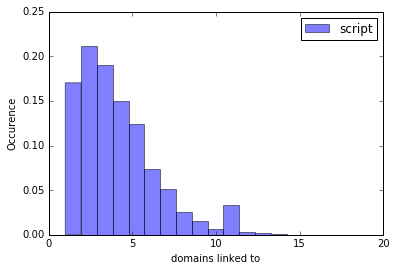

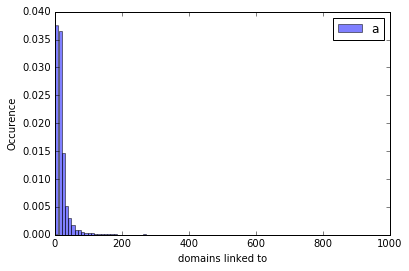

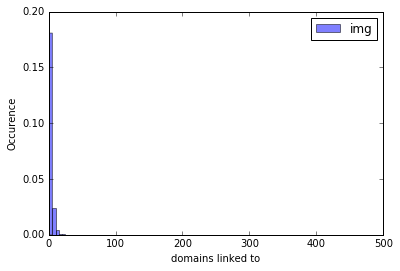

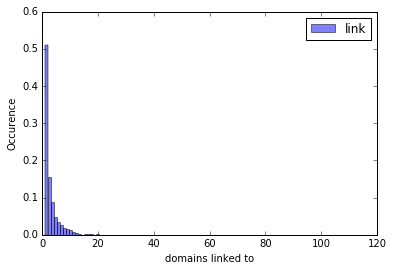

In [6]:
b = {'a':[], 'img':[], 'script':[], 'link':[]}
for key in counts:
    for src in counts[key]:
        b[key].append(len(counts[key][src]))
#print(counts['script']['nytimes.com'])
for i, k in enumerate(b):
    n, bins, patches = plt.hist(b[k], int(min(max(b[k]),100)), normed=1, label=k, alpha=0.5)
    plt.legend()
    plt.xlabel('domains linked to')
    plt.ylabel('Occurence')
    plt.show()

In [7]:
def lessMag(a, b):
    if abs(a) < abs(b):
        return a
    else:
        return b

In [159]:
def makeMutGraph(boss=False, minsamp=2, weight='bold'):
    G = nx.Graph()
    for src in mcounts:
        for dst in mcounts[src]:
            if mcounts[src][dst] > minsamp and mcounts[dst][src] > minsamp:
                G.add_edge(src, dst)

    chunks = [g for g in nx.connected_component_subgraphs(G.to_undirected())]
    meta = nx.Graph()
    for chunk in chunks:
        if len(chunk) > 3:
            meta = nx.compose(meta, chunk)
    if boss:
        meta = max(chunks, key=len)
    good = meta.nodes()
    
    G = nx.Graph()
    
    for src in mcounts:
        for dst in mcounts[src]:
            if src in good and dst in good:
                if mcounts[src][dst] > minsamp and mcounts[dst][src] > minsamp:
                    G.add_edge(src, dst, weight=mcounts[src][dst]+mcounts[dst][src])

    d = [G.degree()[k] for k in G.nodes()]
    mds = np.where(np.array(d) >= sorted(d)[-5])[0]
    for md in mds:
        print(G.nodes()[md] + " : " + str(d[md]))
                    
    pos = graphviz_layout(G, 'neato')

    ec = [0]*len(G.edges())
    ew = [0]*len(G.edges())
    ns = [0]*len(G.nodes())
    for src in mcounts:
        for dst in mcounts[src]:
            if dst in G.nodes() and src in G.nodes():
                ns[G.nodes().index(dst)] += (mcounts[src][dst] / sum([mcounts[src][d] for d in mcounts[src]]))
    ns = [n*1000 for n in ns]
    
    i = 0
    nc = [2 for n in ns]
    for i, n in enumerate(G.nodes()):
        if n in biasnames:
            #print(bias[biasnames.index(n)][7])
            if not bias[biasnames.index(n)][8] == -1:
                #print(n)
                #print(bias[i])
                nc[i] = bias[biasnames.index(n)][8]
                i += 1
            else:
                ns[i] = 0
        else:
            ns[i] = 0
    print(min(ns))
    print(max(ns))
    print(i)
            
    maWe = 0
    miWe = 100
    for i, edge in enumerate(G.edges(data=True)):
        src = edge[0]
        dst = edge[1]
        ec[i] = lessMag(mw[src][dst],mw[dst][src])
        ew[i] = edge[2]['weight']
        ew[i] = math.log(ew[i])
        maWe = max(maWe, ew[i])
        miWe = min(miWe, ew[i])
    print("Min Weight: " + str(miWe))
    print("Max Weight: " + str(maWe))

    plt.figure(1, (30, 30))
    nx.draw(G, pos, node_size=ns, node_color=nc, cmap=plt.cm.RdYlGn, edge_color=ec, edge_cmap=plt.cm.viridis, width=ew)
    nx.draw_networkx_labels(G, pos, font_weight=weight)
    plt.show()

www.washingtonpost.com : 61
www.theguardian.com : 21
www.politico.com : 19
www.huffingtonpost.com : 22
www.nytimes.com : 39
0
2000.8764241893075
933
Min Weight: 1.3862943611198906
Max Weight: 9.172949982757624


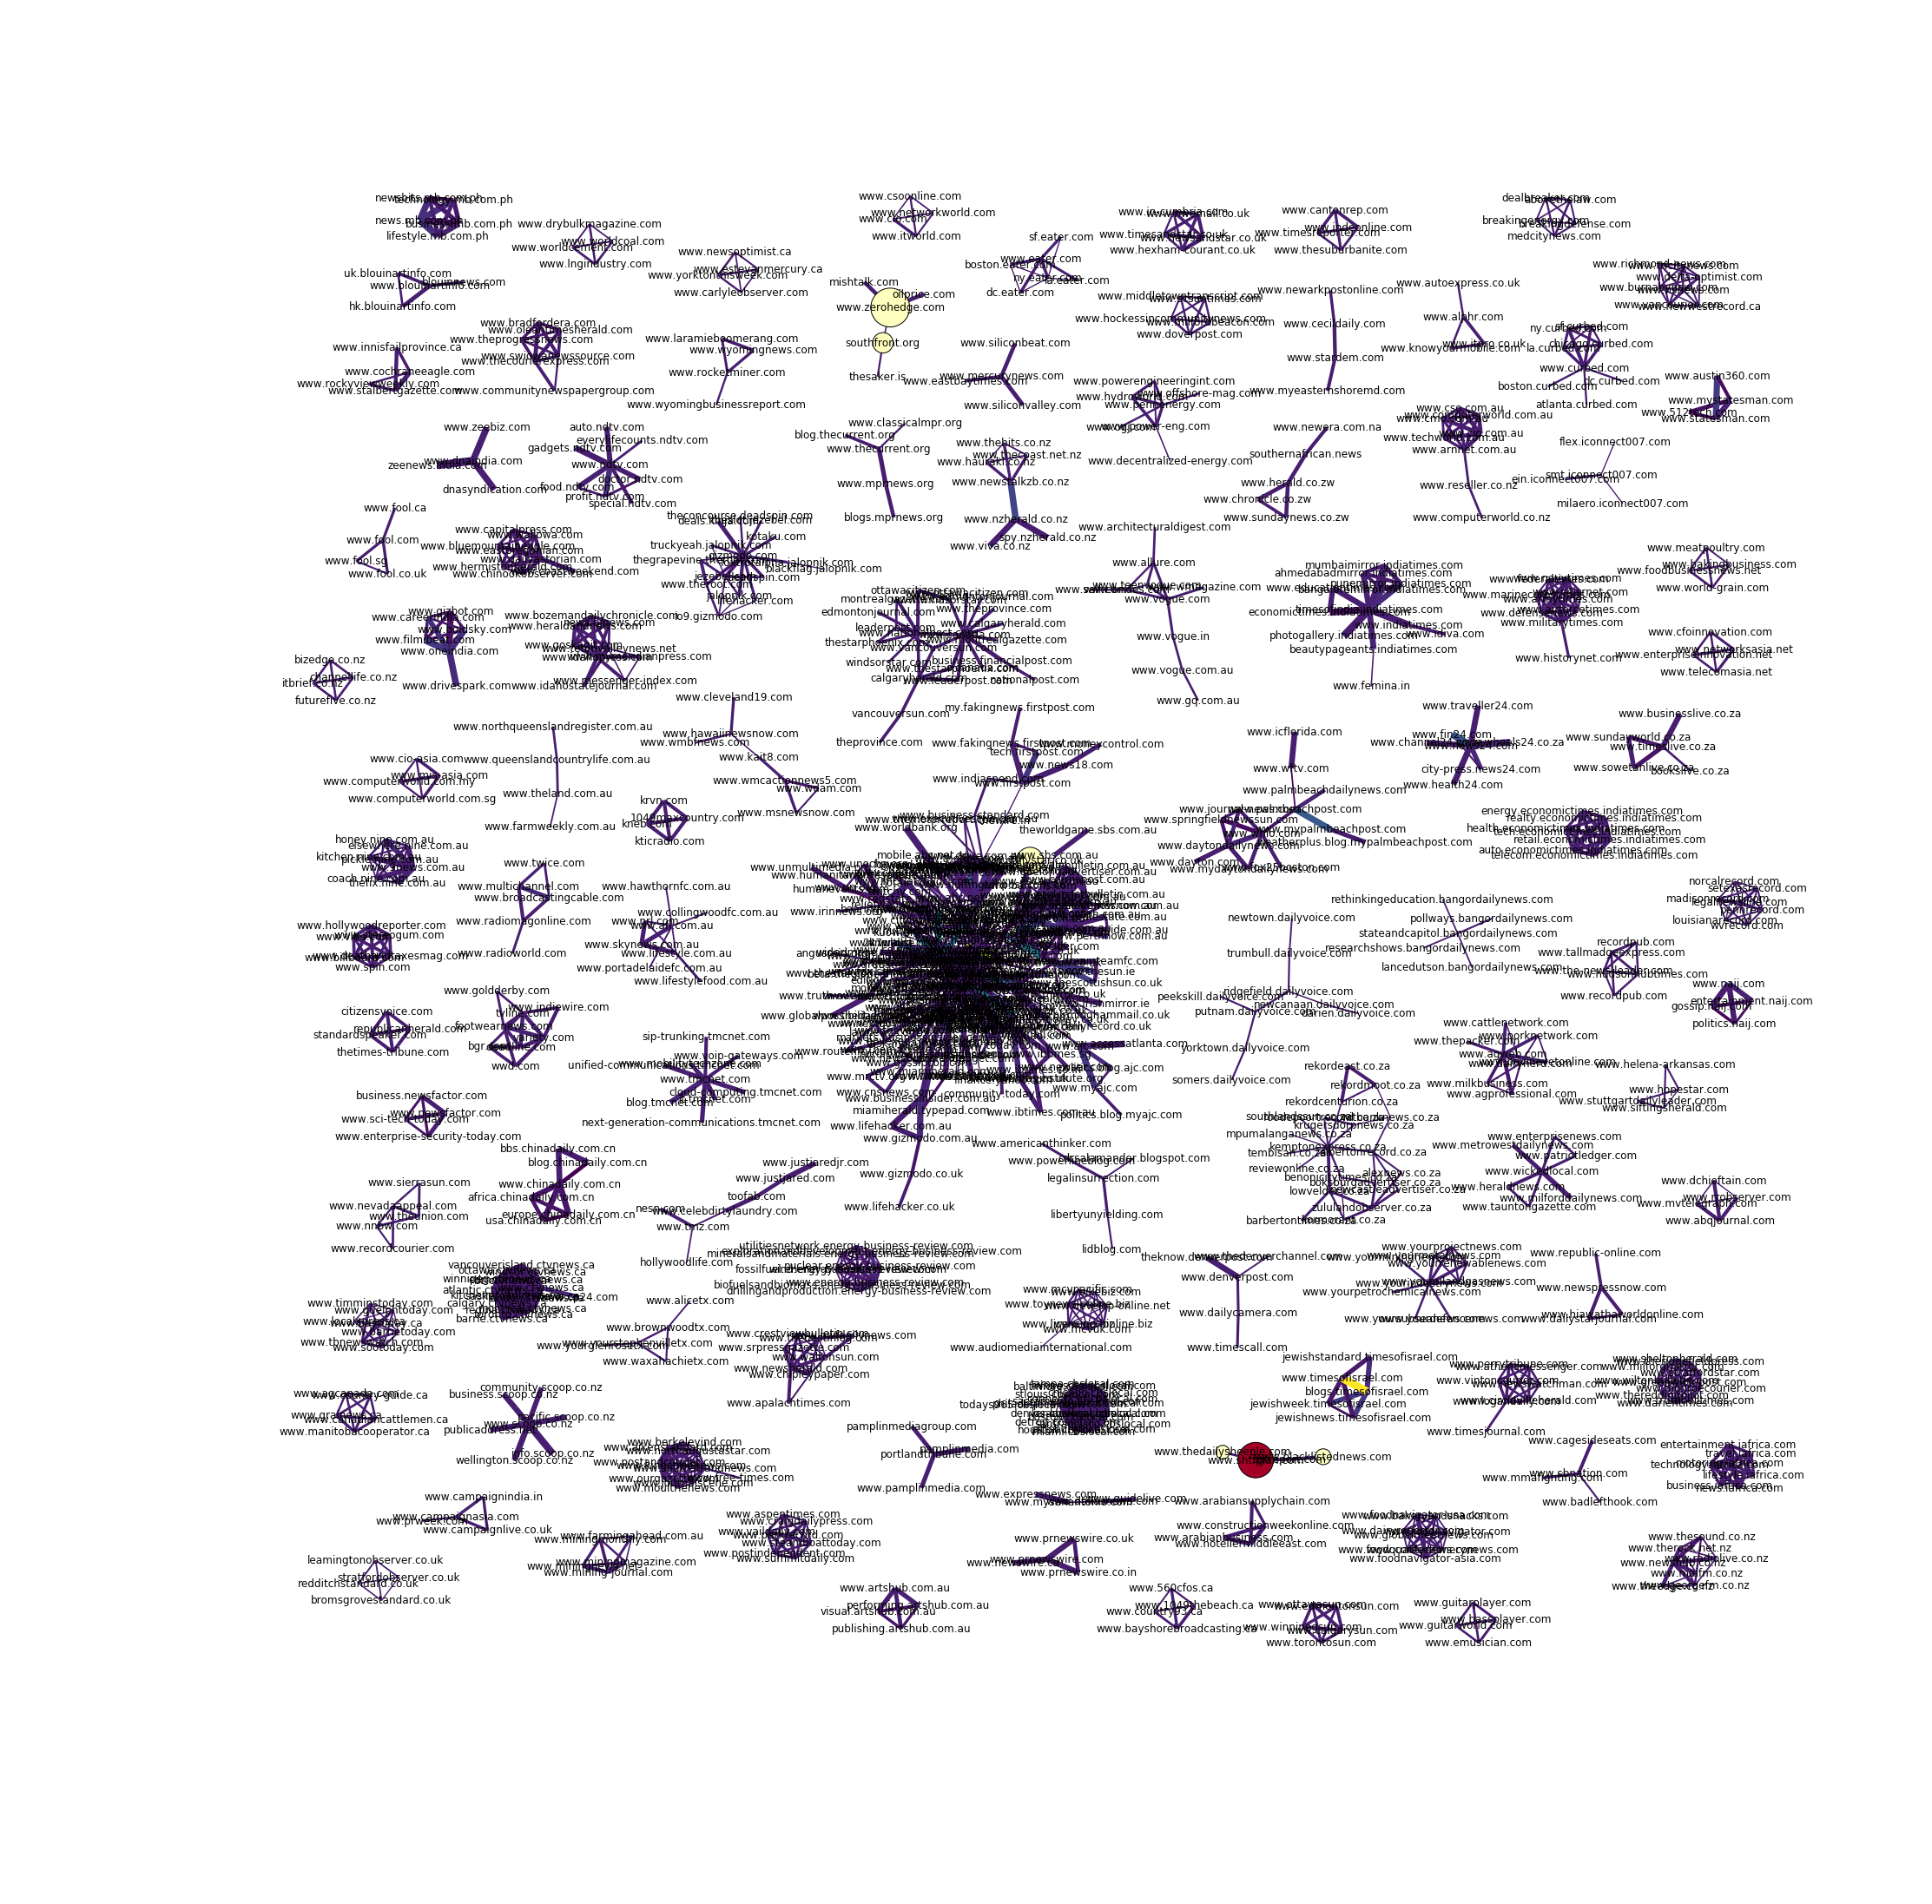

In [160]:
makeMutGraph(minsamp=1, weight='normal')

www.nytimes.com : 39
www.washingtonpost.com : 61
www.theguardian.com : 21
www.huffingtonpost.com : 22
www.politico.com : 19
0
945.4976303317536
264
Min Weight: 1.3862943611198906
Max Weight: 8.963672275615016


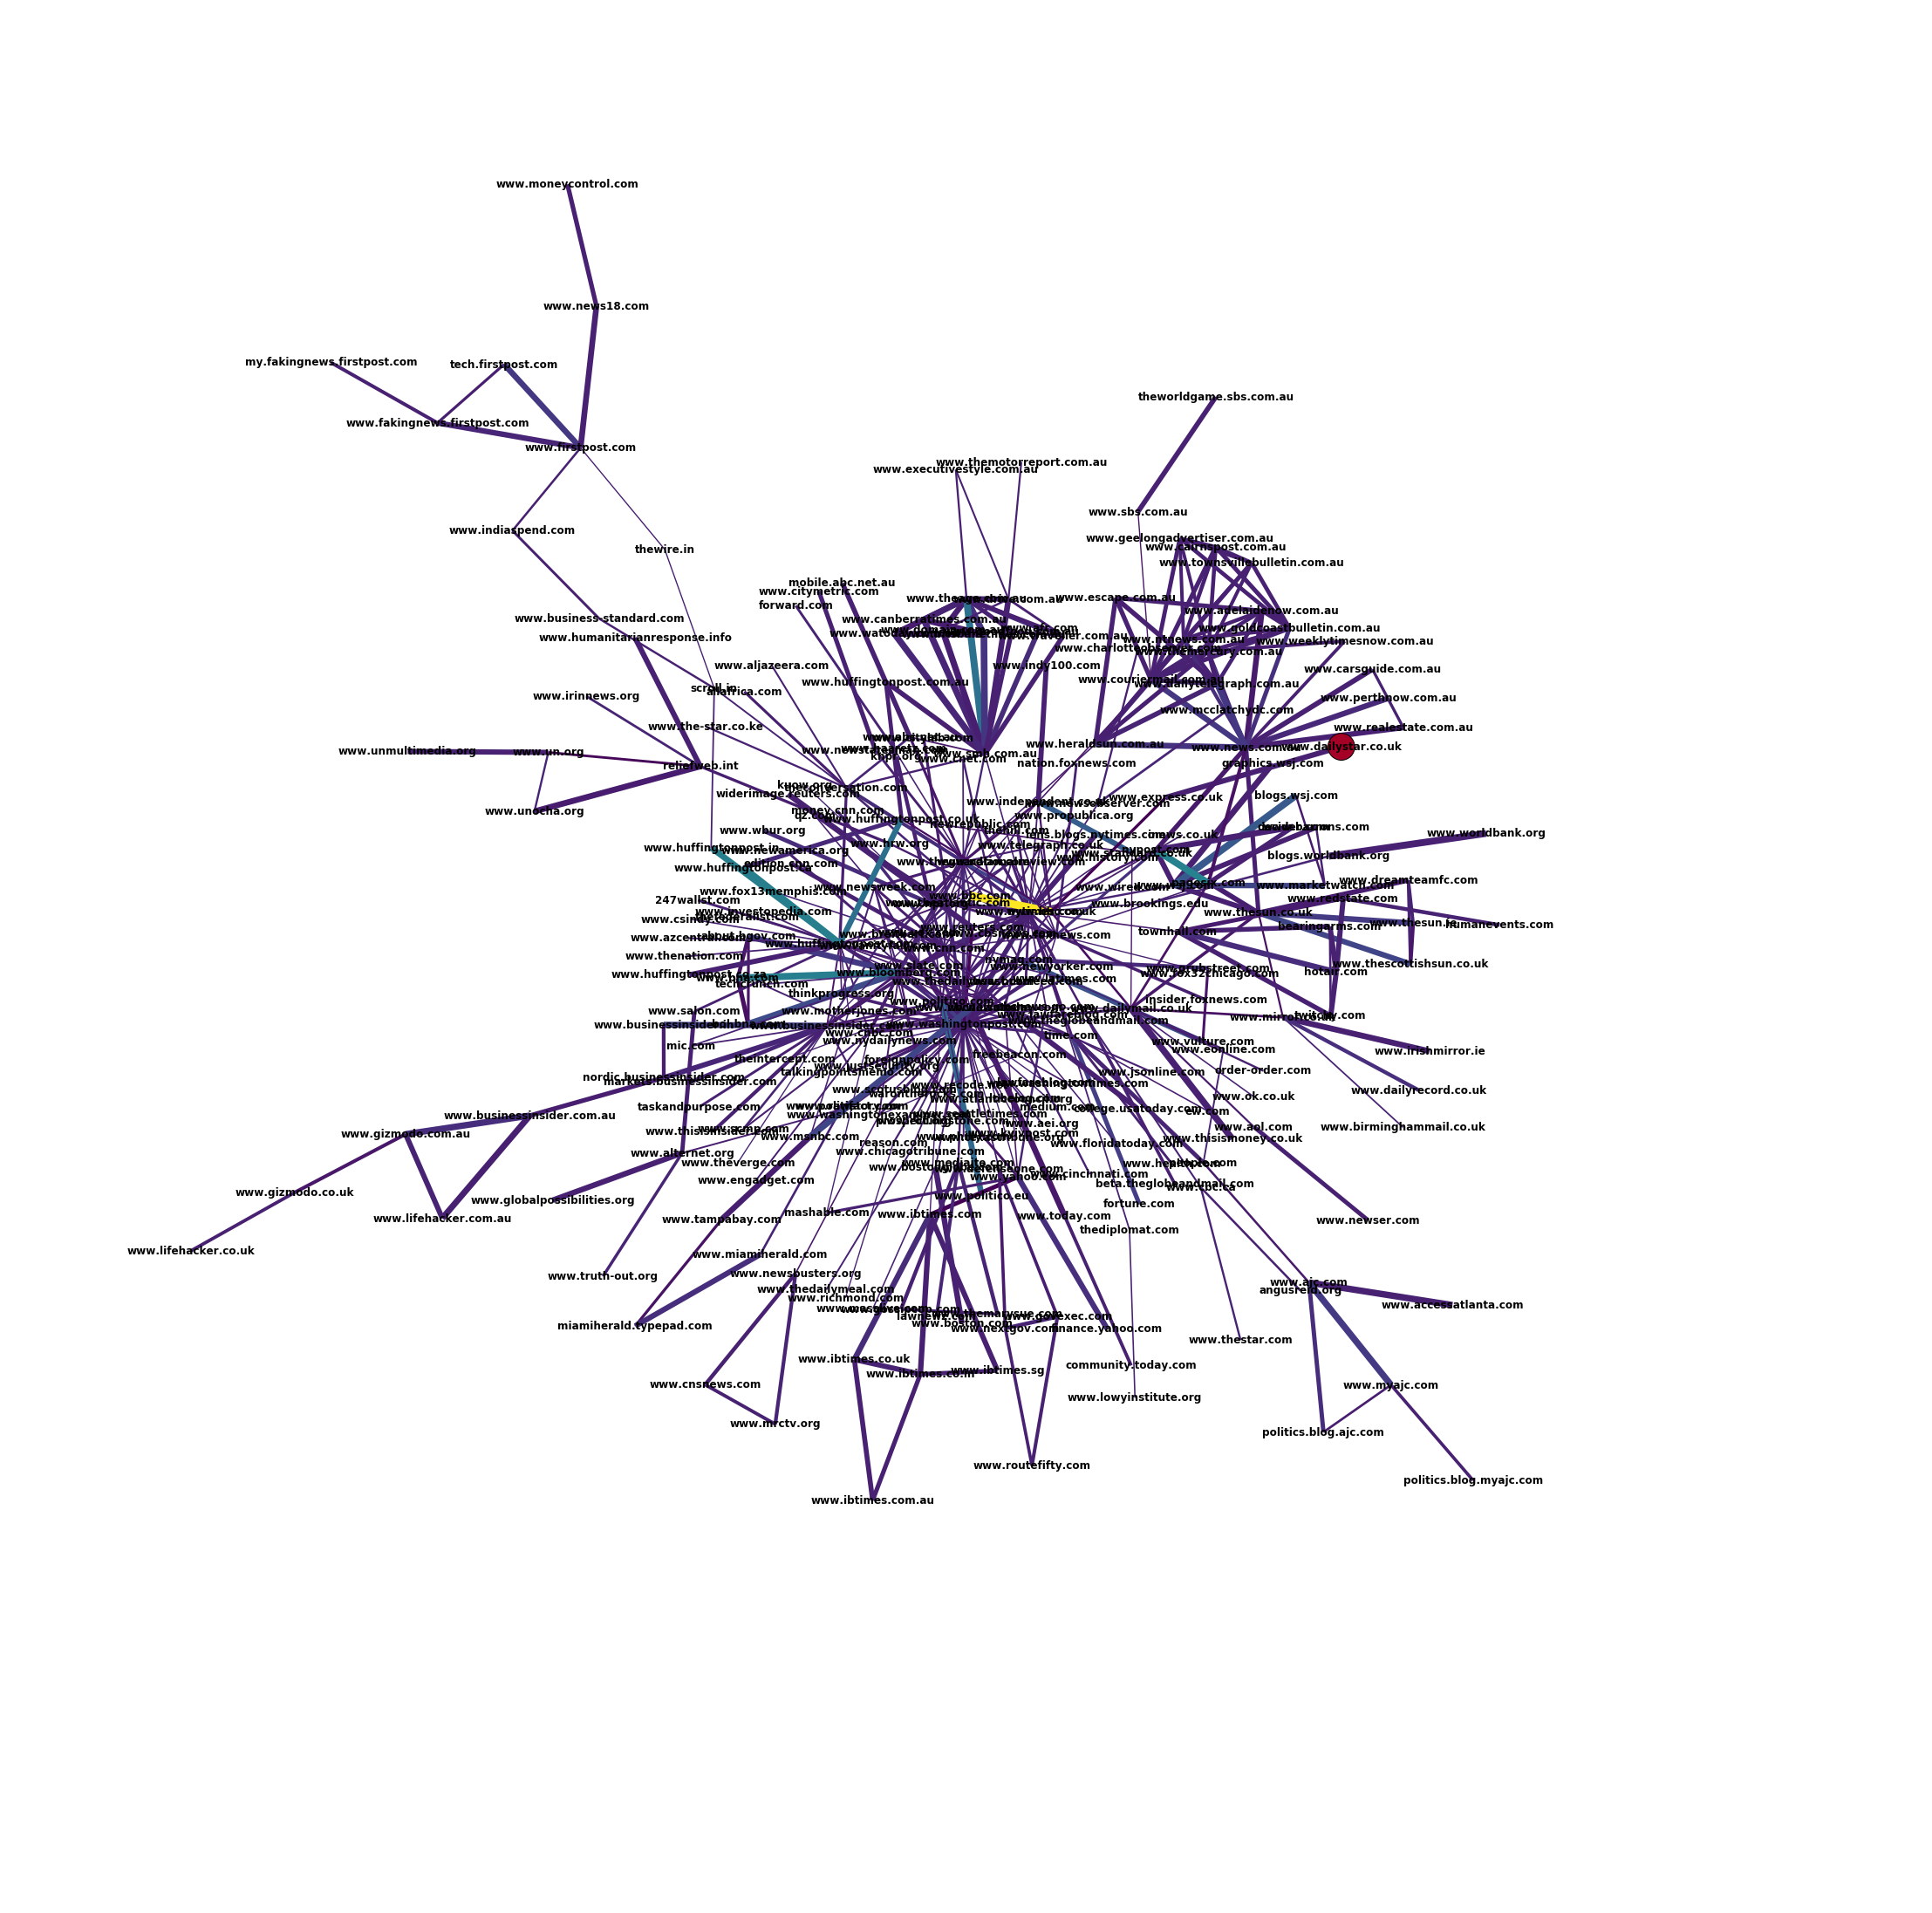

In [161]:
makeMutGraph(boss=True, minsamp=1)

In [80]:
def makeDiGraph(boss=False, key='img', minsamp=100):
    blacklist = ['www.facebook.com', 'facebook.com', 'www.twitter.com', 'twitter.com', 'plus.google.com', 'play.google.com', \
                 'linkedin.com', 'www.instagram.com', 'instagram.com', 'www.youtube.com', 'www.linkedin.com', 'itunes.apple.com']
    P = nx.MultiDiGraph()
    c = counts[key] 
    for src in c:
        for dst in c[src]:
            if c[src][dst] > minsamp and src not in blacklist and dst not in blacklist:
                P.add_edge(src, dst)

    chunks = [p for p in nx.connected_component_subgraphs(P.to_undirected())]
    meta = nx.MultiDiGraph()
    for chunk in chunks:
        if len(chunk) > 3:
            meta = nx.compose(meta, chunk)
    if boss:
        meta = max(chunks, key=len)
    good = meta.nodes()
    
    I = nx.MultiDiGraph()
    for src in c:
        for dst in c[src]:
            if c[src][dst] > minsamp and src in good and dst in good:
                I.add_edge(src, dst, weight=c[src][dst])
    plt.show()
    pos = graphviz_layout(I)
    
    d = [I.degree()[k] for k in I.nodes()]
    mds = np.where(np.array(d) >= sorted(d)[-10])[0]
    for md in mds:
        print(I.nodes()[md] + " : " + str(d[md]))
        #print([key for key in nx.all_neighbors(I, I.nodes()[md])])

    ec = [0]*len(I.edges())
    ew = [0]*len(I.edges())
    ns = [0]*len(I.nodes())
    for src in c:
        for dst in c[src]:
            if dst in I.nodes():
                ns[I.nodes().index(dst)] += c[src][dst]/100
            
    maWe = 0
    miWe = 100
    for i, edge in enumerate(I.edges(data=True)):
        src = edge[0]
        dst = edge[1]
        ec[i] = c[src][dst]
        ew[i] = edge[2]['weight']/10
        ew[i] = math.log(ew[i])
        maWe = max(maWe, ew[i])
        miWe = min(miWe, ew[i])
    print("Min Weight: " + str(miWe))
    print("Max Weight: " + str(maWe))

    plt.figure(1, (30, 30))
    nx.draw(I, pos, node_size=ns, node_color=ns, cmap=plt.cm.viridis, edge_color=ec, edge_cmap=plt.cm.viridis, width=ew)
    nx.draw_networkx_labels(I, pos, font_weight='bold')
    plt.show()

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


www.nzherald.co.nz : 12
news.mb.com.ph : 8
economictimes.indiatimes.com : 9
www.hindustantimes.com : 8
www.news24.com : 10
timesofindia.indiatimes.com : 8
www.chron.com : 12
www.sfgate.com : 15
www.business-standard.com : 8
www.dailymail.co.uk : 12
Min Weight: 4.619073091157083
Max Weight: 9.001099725830965


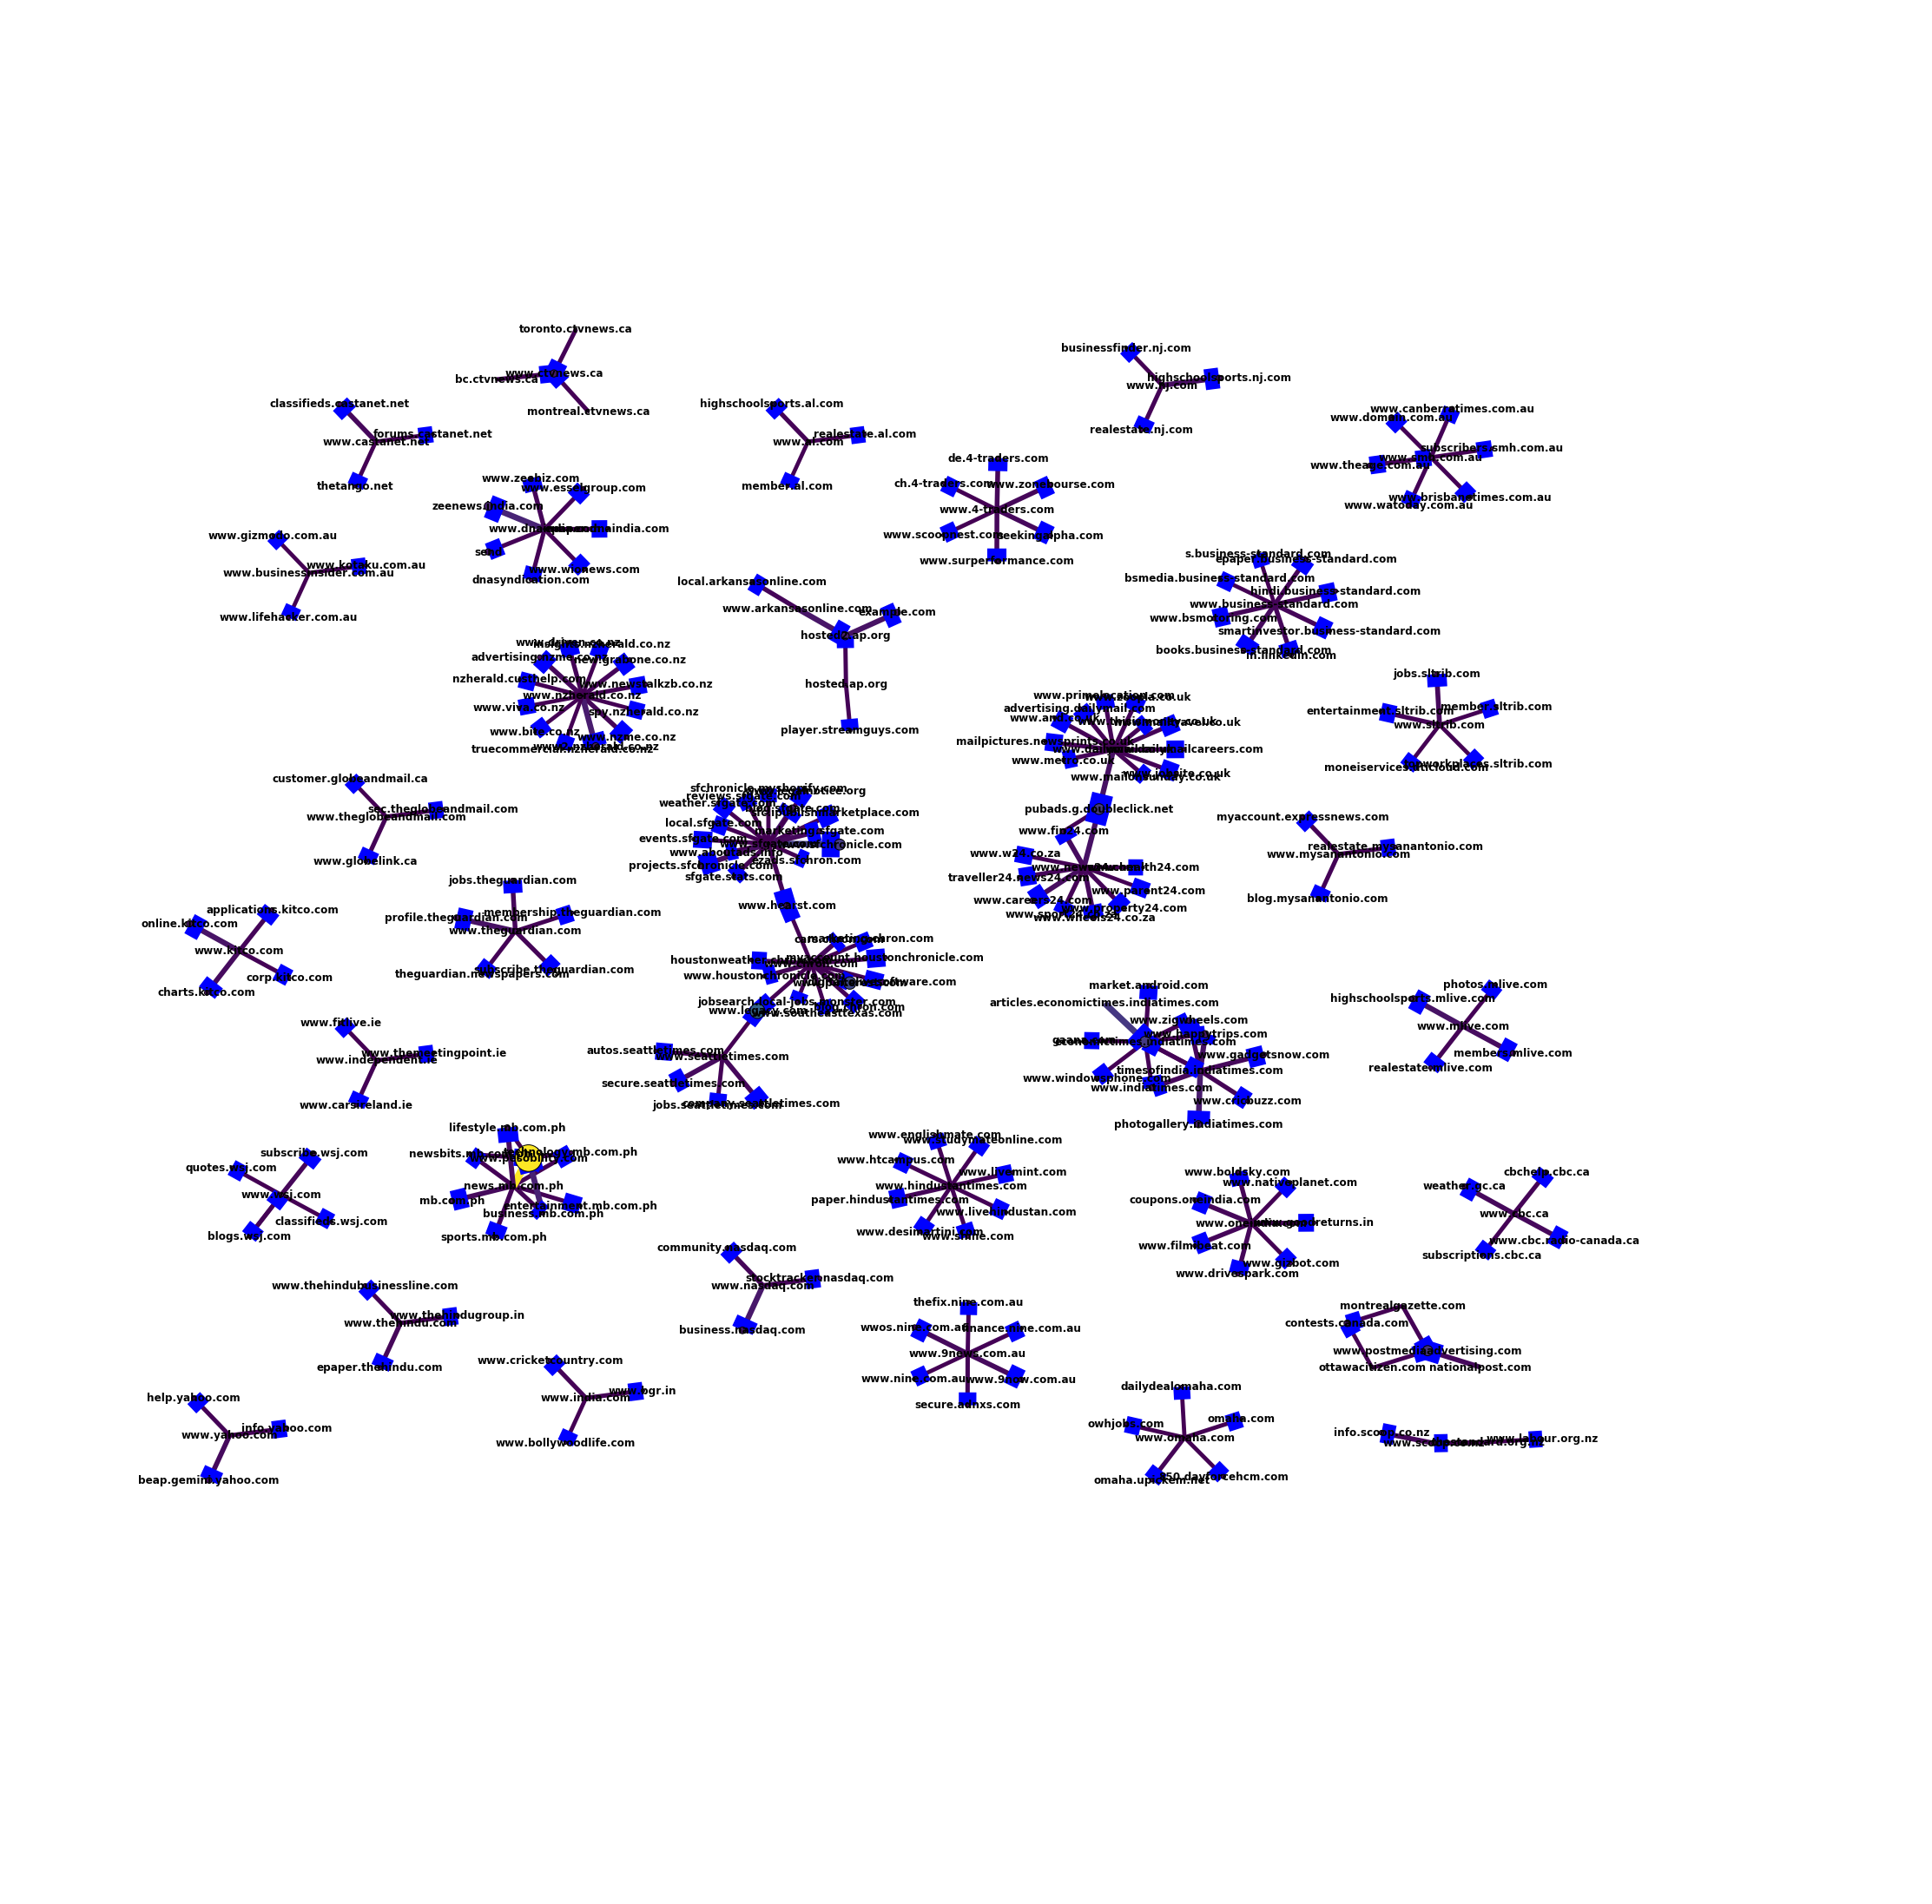

In [81]:
makeDiGraph(key='a', minsamp=1000)

digital.olivesoftware.com : 1
www.pinterest.com : 1
www.legacy.com : 2
weather.sfgate.com : 1
houstonweather.chron.com : 1
www.hearst.com : 2
www.houstonchronicle.com : 1
jobs.seattletimes.com : 1
jobsearch.local-jobs.monster.com : 1
sfc.ipublishmarketplace.com : 1
sfchronicle.myshopify.com : 1
www.sfchronicle.com : 1
secure.seattletimes.com : 1
events.sfgate.com : 1
cars.chron.com : 1
company.seattletimes.com : 1
myaccount.houstonchronicle.com : 1
sfgate.stats.com : 1
www.legalnotice.org : 1
marketing.sfgate.com : 1
blog.sfgate.com : 1
local.sfgate.com : 1
autos.seattletimes.com : 1
ezads.sfchron.com : 1
www.chron.com : 12
marketing.chron.com : 1
www.seattletimes.com : 5
www.sfgate.com : 15
www.aboutads.info : 1
projects.sfchronicle.com : 1
blog.chron.com : 1
www.southeasttexas.com : 1
reviews.sfgate.com : 1
Min Weight: 4.695010889987881
Max Weight: 7.374942445718299


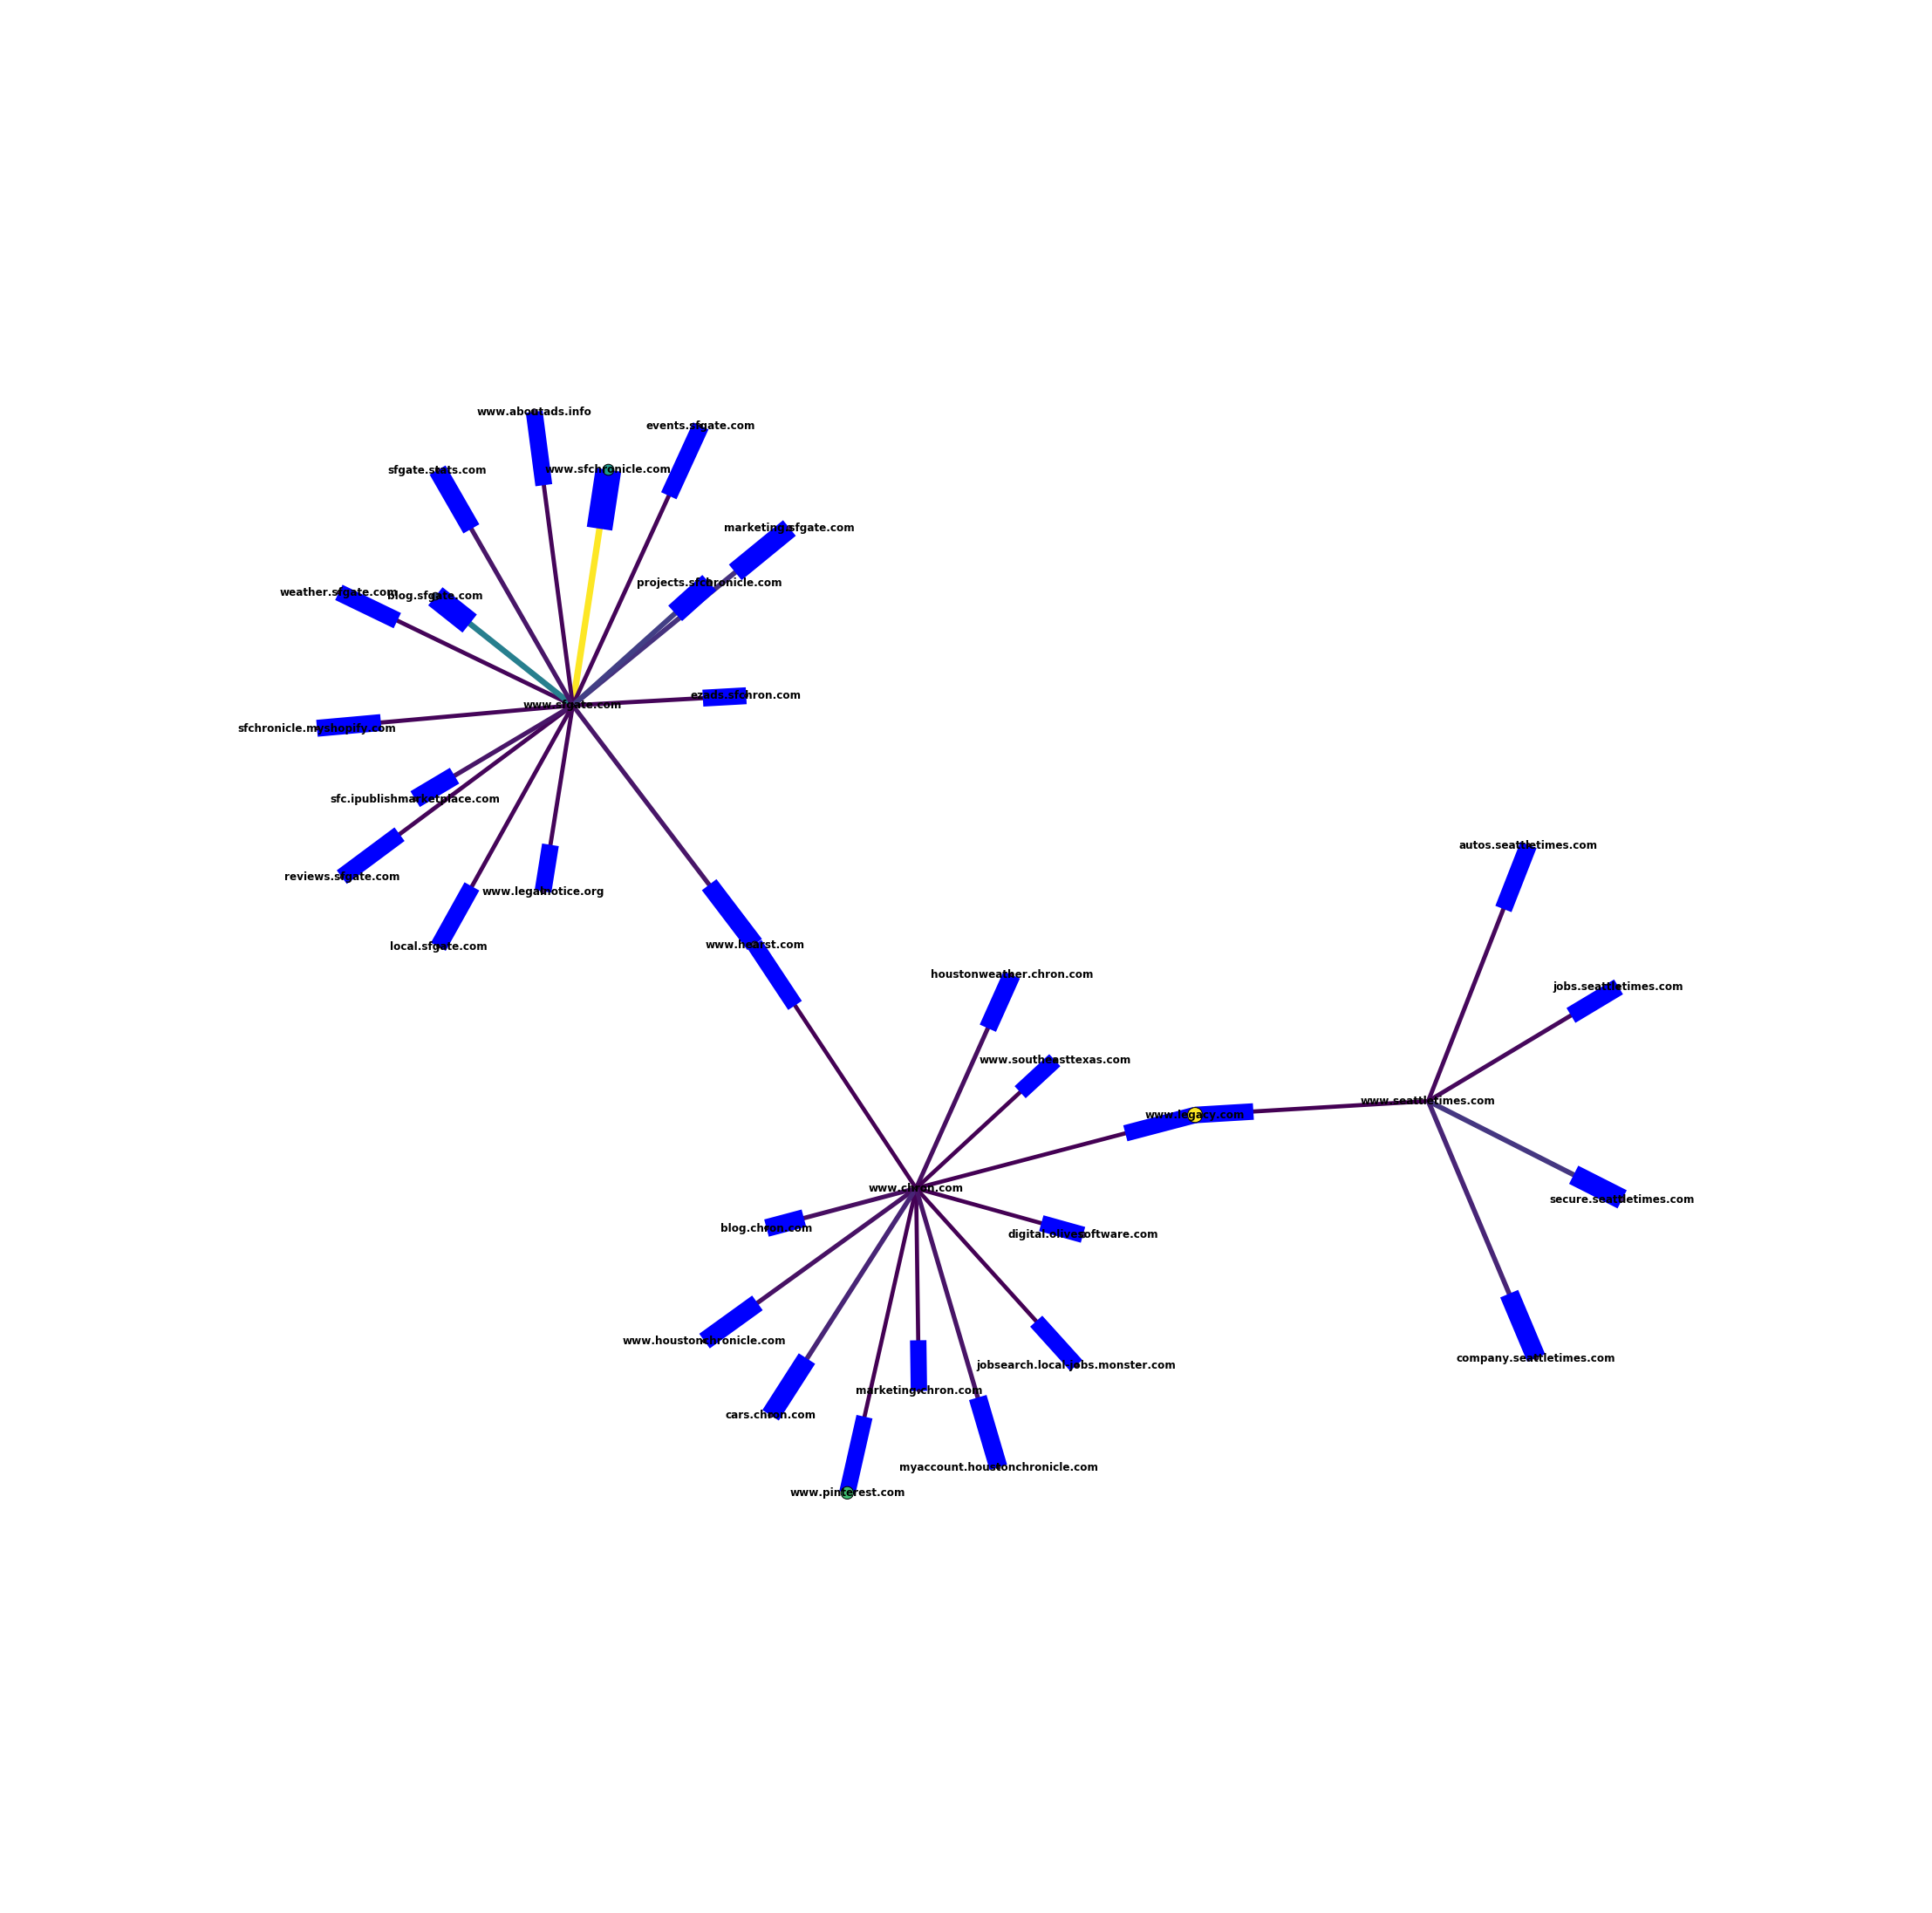

In [82]:
makeDiGraph(boss=True, key='a', minsamp=1000)

In [23]:
fcounts = {'a':{}, 'img':{}, 'script':{}, 'link':{}}
for key in fcounts:
    for src in counts[key]:
        pairs = itertools.combinations(list(counts[key][src].keys()), 2)
        for pair in pairs:
            if pair[0] not in fcounts[key]:
                fcounts[key][pair[0]] = {}
            if pair[1] not in fcounts[key][pair[0]]:
                fcounts[key][pair[0]][pair[1]] = 0
            fcounts[key][pair[0]][pair[1]] += 1

In [14]:
def makeCdnGraph(boss=False):
    blacklist = ['apis.google.com', 'ajax.googleapis.com', 'www.googletagservices.com', 'platform.twitter.com', 'www.google.com', 'widgets.outbrain.com', 'c.amazon-adsystem.com']
    #['fonts.googleapis.com', 'plus.google.com', 'securepubads.g.doubleclick.net', '1.gravatar.com', 'wp.me', 'www.googletagservices.com']
    minsamp = 10
    key = 'script'
    fc = fcounts[key]
    G = nx.Graph()
    for src in fc:
        for dst in fc[src]:
            if fc[src][dst] > minsamp and src not in blacklist and dst not in blacklist:
                G.add_edge(src, dst, weight=fc[src][dst])
    #G = max(nx.connected_component_subgraphs(G), key=len)
    pos = graphviz_layout(G, 'neato')

    d = [G.degree()[k] for k in G.nodes()]
    mds = np.where(np.array(d) >= sorted(d)[-10])[0]
    for md in mds:
        print(G.nodes()[md] + " : " + str(d[md]))
    
    
    ec = [0]*len(G.edges())
    ew = [0]*len(G.edges())
    ns = [0]*len(G.nodes())
    for src in fc:
        for dst in fc[src]:
            if dst in G.nodes() and src in G.nodes():
                ns[G.nodes().index(dst)] += fc[src][dst]
            
    maWe = 0
    miWe = 100
    for i, edge in enumerate(G.edges(data=True)):
        src = edge[0]
        dst = edge[1]
        #print(i)
        ew[i] = edge[2]['weight']
        ew[i] = math.log(ew[i])
        maWe = max(maWe, ew[i])
        miWe = min(miWe, ew[i])
    print("Min Weight: " + str(miWe))
    print("Max Weight: " + str(maWe))

    plt.figure(1, (20, 20))
    nx.draw(G, pos, node_size=ns, node_color=ns, cmap=plt.cm.viridis, edge_color=ew, edge_cmap=plt.cm.viridis, width=ew)
    nx.draw_networkx_labels(G, pos, font_weight='bold')
    plt.show()

launch.newsinc.com : 26
s0.wp.com : 31
edge.quantserve.com : 18
pagead2.googlesyndication.com : 13
s1.wp.com : 18
s2.wp.com : 20
stats.wp.com : 15
a.postrelease.com : 17
tags.crwdcntrl.net : 13
ad.crwdcntrl.net : 13
platform.linkedin.com : 13
Min Weight: 2.3978952727983707
Max Weight: 6.113682179832232


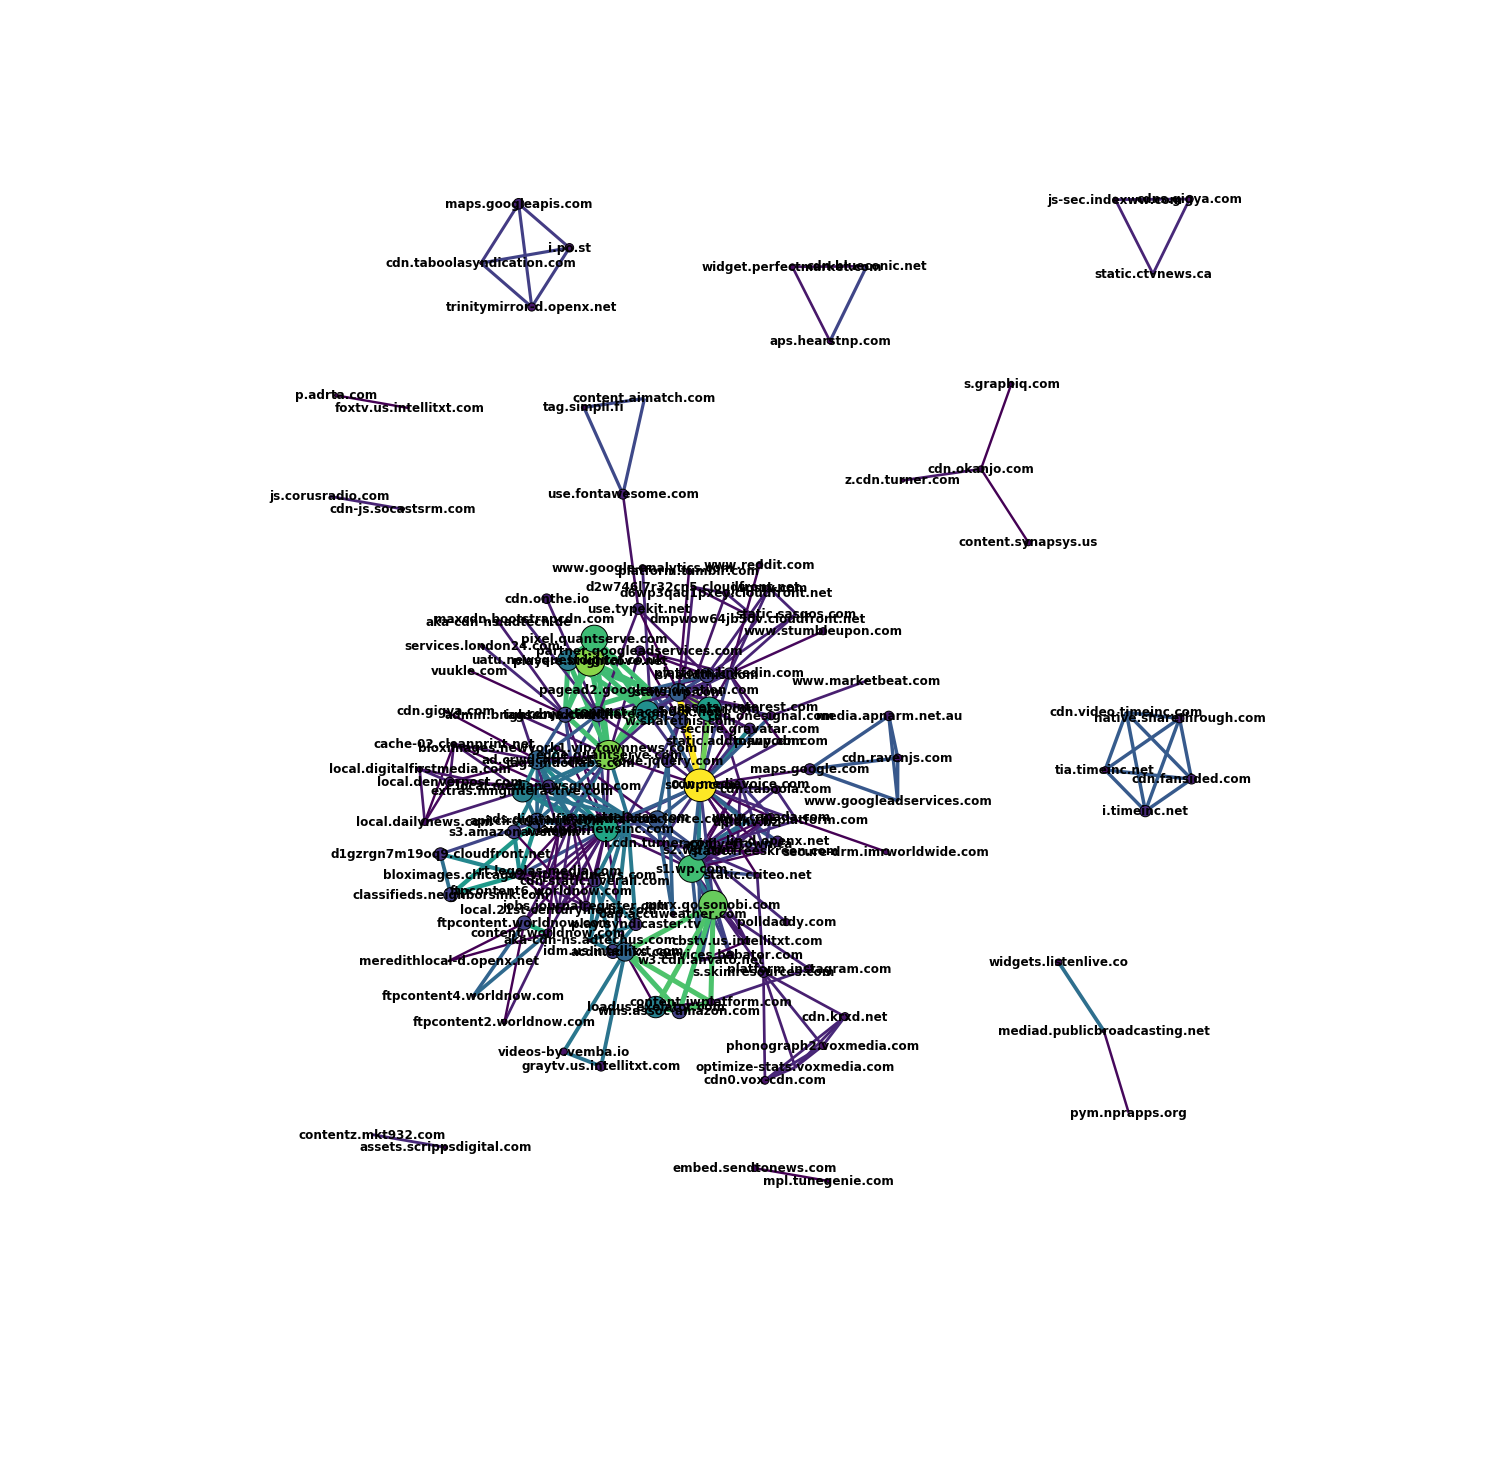

In [15]:
makeCdnGraph()